In [37]:
from os.path import join as pjoin
import datetime
import os
import re

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

import torchvision
from torchvision.io import read_image

import torchinfo

# Константы


In [38]:
classes = np.array( ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
    'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu',
    'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
    'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover',
    'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle',
    'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = classes.shape[0]
WEIGHT_SAVER = "last" # "all" / "nothing" / "last"
NUM_WORKERS = 4
image_resize_train = (64, 64)
learnLogFile = None
createLogFolder = True
epochs = 25

batch_size = 128

# Transformers

In [39]:
transform = torchvision.transforms.Compose([
    # torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(image_resize_train),
    torchvision.transforms.CenterCrop(image_resize_train),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

class LabelTransformer():
    def __init__(self, initial_list = classes):
        self.initial_list = initial_list
    
    def __call__(self, val):
        if type(val) == str:
            return self.toInt(val)
        elif type(val) == int or type(val) == np.int64:
            return self.toStr(val)
        return None

    def toInt(self, label : str) -> int:
        return np.where(self.initial_list == label)[0][0]
    
    def toStr(self, ind : int) -> str:
        return self.initial_list[ind]

# Датасет
Train + Valid

In [40]:
full_dataset = torchvision.datasets.ImageFolder(root="dataset/characters/", transform=transform)
    
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

## Предпросмотр датасета


<Figure size 640x480 with 0 Axes>

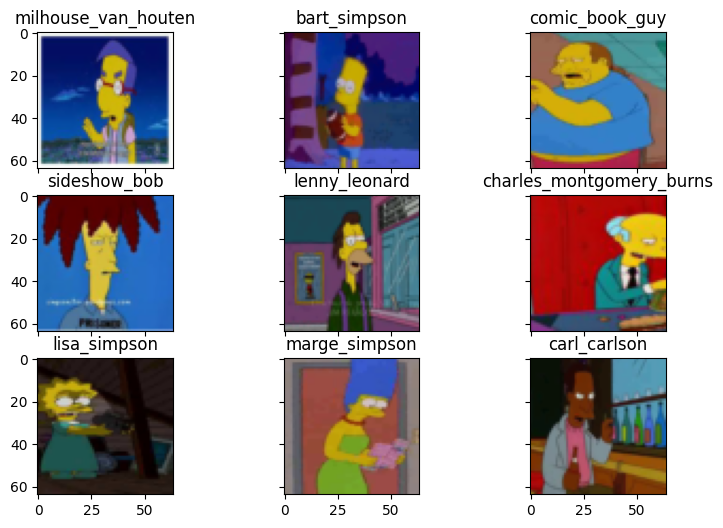

In [41]:
import matplotlib.pyplot as plt

figure = plt.figure()

def imshow(img, title, plt_ax=plt):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    img = std * img + mean
    plt_ax.imshow(img)
    plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), sharey=True, sharex=True)

for fig_x in ax.flatten():
    character_index = int(np.random.uniform(0, len(train_dataset)))
    img, label = train_dataset[character_index]
    label = LabelTransformer()(label)
    imshow(img.data.cpu(), title=label, plt_ax=fig_x)

# Модель

In [42]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.shuffle1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        ), nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.shuffle2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        ), nn.Sequential(
            nn.Conv2d(512, 512,3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True))
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.res = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(1024, len(classes))
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.shuffle1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.shuffle2(x) + x
        x = self.conv5(x)
        x = self.res(x)
        return x


# Dataloader's

In [43]:
model = Model()
trained = False

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model = nn.DataParallel(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( 
    params=model.parameters(),
    lr=0.01,
    momentum=0.9,
)

scheduler = ReduceLROnPlateau(optimizer, 'min')

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

if createLogFolder:
    logLearnFolder = f"{os.path.abspath('.')}/log {datetime.datetime.now()}"
    os.makedirs(logLearnFolder)
    logLearnFileName = f"{logLearnFolder}/log.txt"
    learnLogFile = open(logLearnFileName, 'w', encoding='utf8')

print(torchinfo.summary(model, input_size=(batch_size, 3, 64, 64)))
if learnLogFile is not None: learnLogFile.write(str(torchinfo.summary(model, input_size=(batch_size, 3, 64, 64))))
if learnLogFile is not None: learnLogFile.write('\n')

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [128, 42]                 --
├─Sequential: 1-1                        [128, 64, 64, 64]         --
│    └─Conv2d: 2-1                       [128, 64, 64, 64]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 64, 64]         128
│    └─ReLU: 2-3                         [128, 64, 64, 64]         --
├─Sequential: 1-2                        [128, 128, 32, 32]        --
│    └─Conv2d: 2-4                       [128, 128, 64, 64]        73,856
│    └─BatchNorm2d: 2-5                  [128, 128, 64, 64]        256
│    └─ReLU: 2-6                         [128, 128, 64, 64]        --
│    └─MaxPool2d: 2-7                    [128, 128, 32, 32]        --
├─Sequential: 1-3                        [128, 128, 32, 32]        --
│    └─Sequential: 2-8                   [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 128, 32, 32]        147,584
│

# Шаг обучения и валидации

In [44]:

def train_step():
    model.train()
    running_loss = 0.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()

def valid_step():
    model.eval()
    acc = MulticlassAccuracy(num_classes=len(classes), average="micro")
    recall = MulticlassRecall(num_classes=len(classes), average="macro")
    precision = MulticlassPrecision(num_classes=len(classes), average="macro")
    acc.to(device)
    recall.to(device)
    precision.to(device)
    
    running_loss = 0.

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            acc.update(output, labels)
            recall.update(output, labels)
            precision.update(output, labels)

            loss = criterion(output, labels)
            running_loss += loss

        valid_loss = running_loss / len(valid_dataloader)

        return valid_loss.item(), acc.compute().item(), recall.compute().item(), precision.compute().item()

train_losses = []
valid_losses = []
valid_accs = []
valid_recs = []
valid_precs = []

# Цикл обучения

In [45]:
from tqdm import tqdm

best_loss = 10000

trained = True

for epoch in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc, valid_recall, valid_precision = valid_step()
    scheduler.step(valid_loss)
    
    if WEIGHT_SAVER != "nothing" and valid_loss < best_loss and  epoch > 3:
        best_loss = valid_loss
        
        print(f"Saved weights with acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f} | loss: {valid_loss:.4f}")
        if learnLogFile is not None: learnLogFile.write(f"Saved weights with acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f} | loss: {valid_loss:.4f}\n")

        if WEIGHT_SAVER == "all":
            torch.save(model.state_dict(), f"./{logLearnFolder}_{epoch}.pth")
        elif WEIGHT_SAVER == "last":
            torch.save(model.state_dict(), f"./{logLearnFolder}_last.pth")
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_recs.append(valid_recall)
    valid_precs.append(valid_precision)
    
    if learnLogFile is not None: learnLogFile.write(f"[{epoch}] acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f}  | train/valid loss: {train_loss:.4f}/{valid_loss:.4f}\n")
    pbar.set_description(f'acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f}  | train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

if learnLogFile is not None: learnLogFile.close()

acc/rec/prec: 0.79/0.46/0.60  | train/valid loss: 0.7131/0.9205:  16%|█▌        | 4/25 [01:15<06:37, 18.93s/it]

# Отображение графиков

### loss

In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.plot(np.arange(3, len(train_losses)), train_losses[3:], label='train')
plt.plot(np.arange(3, len(valid_losses)), valid_losses[3:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### accuracy

In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.plot([0] + valid_accs, label='accuracy')
plt.plot([0] + valid_precs, label='precision')
plt.plot([0] + valid_recs, label='recall')
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

# Проверка на тестовом датасете

### Tranform + dataset class

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(image_resize_train),
    torchvision.transforms.CenterCrop(image_resize_train),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
    
class SimpsonsTestDataset(Dataset):
    def __init__(self, img_dir, transform = None, label_transform = None):
        self.files = []
        for r, dir, files in os.walk(img_dir):
            self.files += files
        self.calculateClasses()
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform

    def extractName(self, s):
        se = re.search(r"[a-zA-Z_]+[^\d]?", s)
        return se.group(0)[:-1]

    def calculateClasses(self):
        self.s = set()
        for i in self.files:
            self.s.add(self.extractName(i))
        return list(self.s)
    
    @property
    def classes(self):
        return list(self.s)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.files[index])
        image = read_image(img_path)
        label = self.extractName(self.files[index])

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

## Проверка

In [ ]:
test_dataset = SimpsonsTestDataset("dataset/kaggle_simpson_testset", transform=transform, label_transform=LabelTransformer())

test_dataloader = DataLoader(   
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

if not trained:
    model = Model()
    model.to(device)
    model.load_state_dict(torch.load("/home/e.babenko1/AI_Tasks/01_Task/2SufflesWeights5Convs [43ep].pth"))

def test_metrics_per_class(model, testloader):
    acc = MulticlassAccuracy(num_classes=len(classes), average=None)
    recall = MulticlassRecall(num_classes=len(classes), average=None)
    precision = MulticlassPrecision(num_classes=len(classes), average=None)
    acc.to(device)
    recall.to(device)
    precision.to(device)

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            acc(outputs, labels)
            recall(outputs, labels)
            precision(outputs, labels)
    
    accuracy_per_class = {classname: val.item() for classname, val in zip(classes, acc.compute())}
    recall_per_class = {classname: val.item() for classname, val in zip(classes, recall.compute())}
    precision_per_class = {classname: val.item() for classname, val in zip(classes, precision.compute())}
    return {"accuracy": accuracy_per_class, "recall": recall_per_class, "precision": precision_per_class}

metrics = test_metrics_per_class(model, valid_dataloader)
print(metrics)

## Отобразить

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,8))

for (metricName, mVal), ax in zip(metrics.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.title(metricName)
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))

plt.show()